## GAN starter code
Corresponding tutorial: [https://youtu.be/_pIMdDWK5sc](https://youtu.be/_pIMdDWK5sc)

In [1]:
# !pip install pytorch-lightning

In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [5]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)

In [13]:
# TODO: GAN

class GAN(pl.LightningModule):
    def __init__(self, latent_dim = 100, lr = 0.0002):
        super().__init__()
        self.save_hyperparameters()
        
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        
        # random noise 
        self.validation_z  = torch.randn(6, self.hparams.latent_dim)
        
    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch
        batch_size = real_imgs.shape[0]
        
        z = torch.randn(batch_size, self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        fake_imgs = self(z)
        # Train Generator
        if optimizer_idx == 0:
            # Generate fake images
            
            # Loss measures generator's ability to fool the discriminator
            # train generator to maximize log(D(G(z)))
            y_hat = self.discriminator(fake_imgs)
            y = torch.ones_like(y_hat)
            g_loss = self.adversarial_loss(y_hat, y)
            
            log_dict = {"g_loss": g_loss}
            return {"loss":g_loss, "progress_bar": log_dict, "log":log_dict}
        
        # Train Discriminator
        if optimizer_idx == 1:
            # Combine losses and calculate gradients
            # maximize log(D(x)) + log(1 - D(G(z)))
            # Measure discriminator's ability to classify real from generated samples
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones_like(y_hat_real)
            real_loss = self.adversarial_loss(y_hat_real, y_real)

            # FAKE            
            y_hat_fake = self.discriminator(fake_imgs.detach())
            y_fake = torch.zeros_like(y_hat_fake)
            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            
            d_loss = (real_loss + fake_loss) / 2
                        
            log_dict = {"d_loss": d_loss}
            
            return {"loss":d_loss, "progress_bar": log_dict, "log":log_dict}
        
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = 0.5
        b2 = 0.999
        
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], [] # empty list for schedulers
    
    def plot_imgs(self):
        z = self.validation_z
        sammple_imgs = self(z).detach().cpu()
        
        print("epoch: ", self.current_epoch)
        fig = plt.figure(figsize=(12, 6))
        for i in range(6):
            plt.subplot(2, 3, i+1)
            plt.imshow(sammple_imgs[i][0], cmap="gray")
            plt.title("Fake")
            plt.axis("off")
        plt.show()
        
def on_epoch_end(self):
    self.plot_imgs()        

In [18]:
dm = MNISTDataModule()
model = GAN(latent_dim=5)


epoch:  0


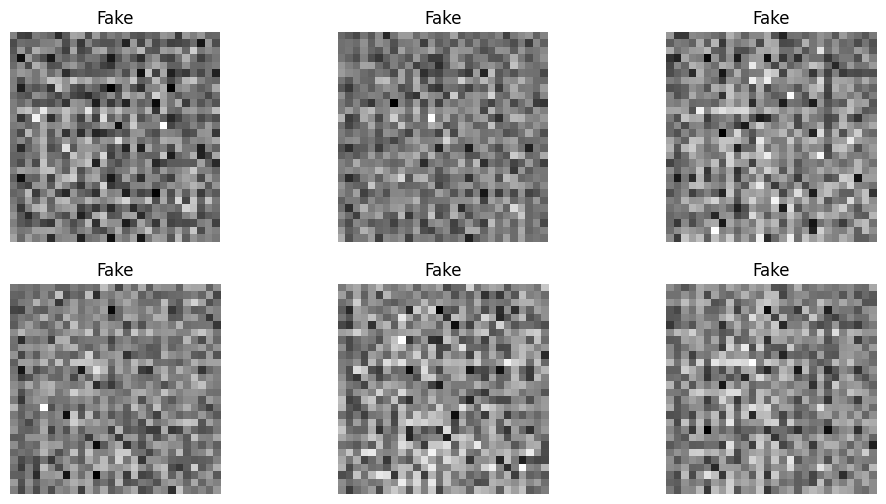

In [19]:
model.plot_imgs()

In [20]:
trainer = pl.Trainer(gpus=1, max_epochs=20)
trainer.fit(model, dm)

/home/garlan/miniconda3/envs/mltest/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/garlan/miniconda3/envs/mltest/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 60.6 K
1 | discriminator | Discr

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


epoch:  20


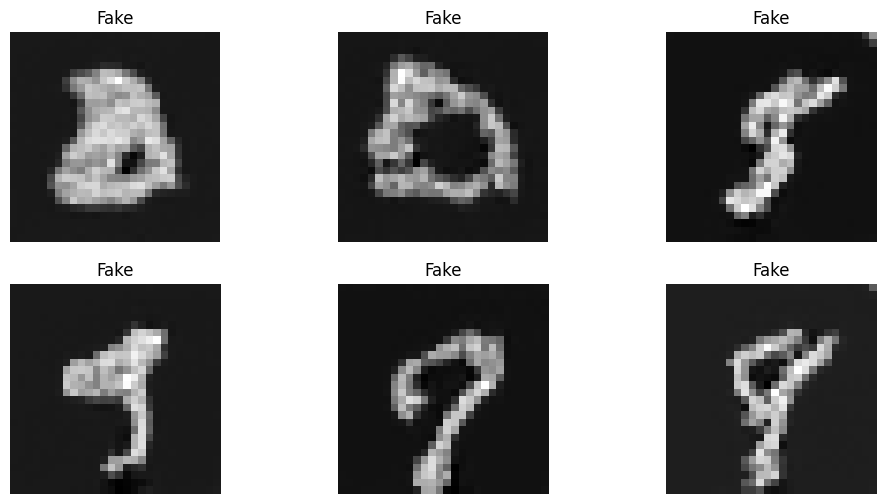

In [21]:
model.plot_imgs()